In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['figure.figsize'] = [5, 5]

from ir_dataset import IRDataSet

# Handy function for visualization
def sequence_to_video(sequence):
    frames = []
    fig = plt.figure(figsize=(3.2,2.4))
    for img in sequence:
        frames.append([plt.imshow(img, animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
    plt.close()
    return ani.to_html5_video()

def iterator_to_numpy_array(raw):
    return np.array(*[list(raw)])

# Testing correlation

In [41]:
from skimage.feature import greycomatrix, greycoprops
from scipy import stats
from sklearn.preprocessing import minmax_scale

First, let's load the data

In [75]:
data = IRDataSet()

def load_sequence_for_label(label = 2):
    sequence_iterator = data.get_sequences_for_label(label=label, limit=5)
    sequences = iterator_to_numpy_array(sequence_iterator)
    only_frames = sequences[...,4]
    return only_frames

Now extract different features
\
We end up with an array of shape (#sequences, #frames, #features)
\
Features are extracted for every frame, _not_ for every sequence.

In [118]:
feature_types = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM', 'sum over binary image']

def calculate_features(frame):
    new_frame = np.zeros_like(frame)
    new_frame[frame!=0] = 1
    gcm = greycomatrix(new_frame, [1,2,4,8], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=2)
    gcm2 = np.sum(gcm, axis=2)
    gcm2 = np.sum(gcm2, axis=2)
    gcm2 = np.expand_dims(gcm2, axis=2)
    gcm2 = np.expand_dims(gcm2, axis=3)
    summation = np.sum(new_frame) / 768.0
    features = np.array([greycoprops(gcm2, feature) for feature in feature_types[:6]] + [summation])
    return features.reshape((len(feature_types)))

def calculate_features_for_sequences(sequences):
    frame_feature_list = [
        [
            calculate_features(frame)
            for frame in sequence
        ]
        for sequence in sequences
    ]
    return frame_feature_list

To calculate a single feature for each sequence from the features of each frame of the sequence we need to combine them in some way.
\
e.g. we could sum them up

In [5]:
sequences = load_sequence_for_label()
features = calculate_features_for_sequences(sequences)
np.sum(features, axis=1)

Okay, now that we've got our features let's check how they correlate.
\
To do so, we need to calculate the sequence features for sequences from each label category.
\
If they correlate, we should be able to see a relation between the axis.

In [119]:
labels = [0,1,2,3]

all_sequences = [
    load_sequence_for_label(label)
    for label in labels
]

all_features = [
    calculate_features_for_sequences(label_sequences)
    for label_sequences in all_sequences
]

means = np.array([
    stats.trim_mean(label_features, axis=1, proportiontocut=0.1)
    #np.sum(label_features, axis=1)
    for label_features in all_features
])

Let's check our hypothesis:

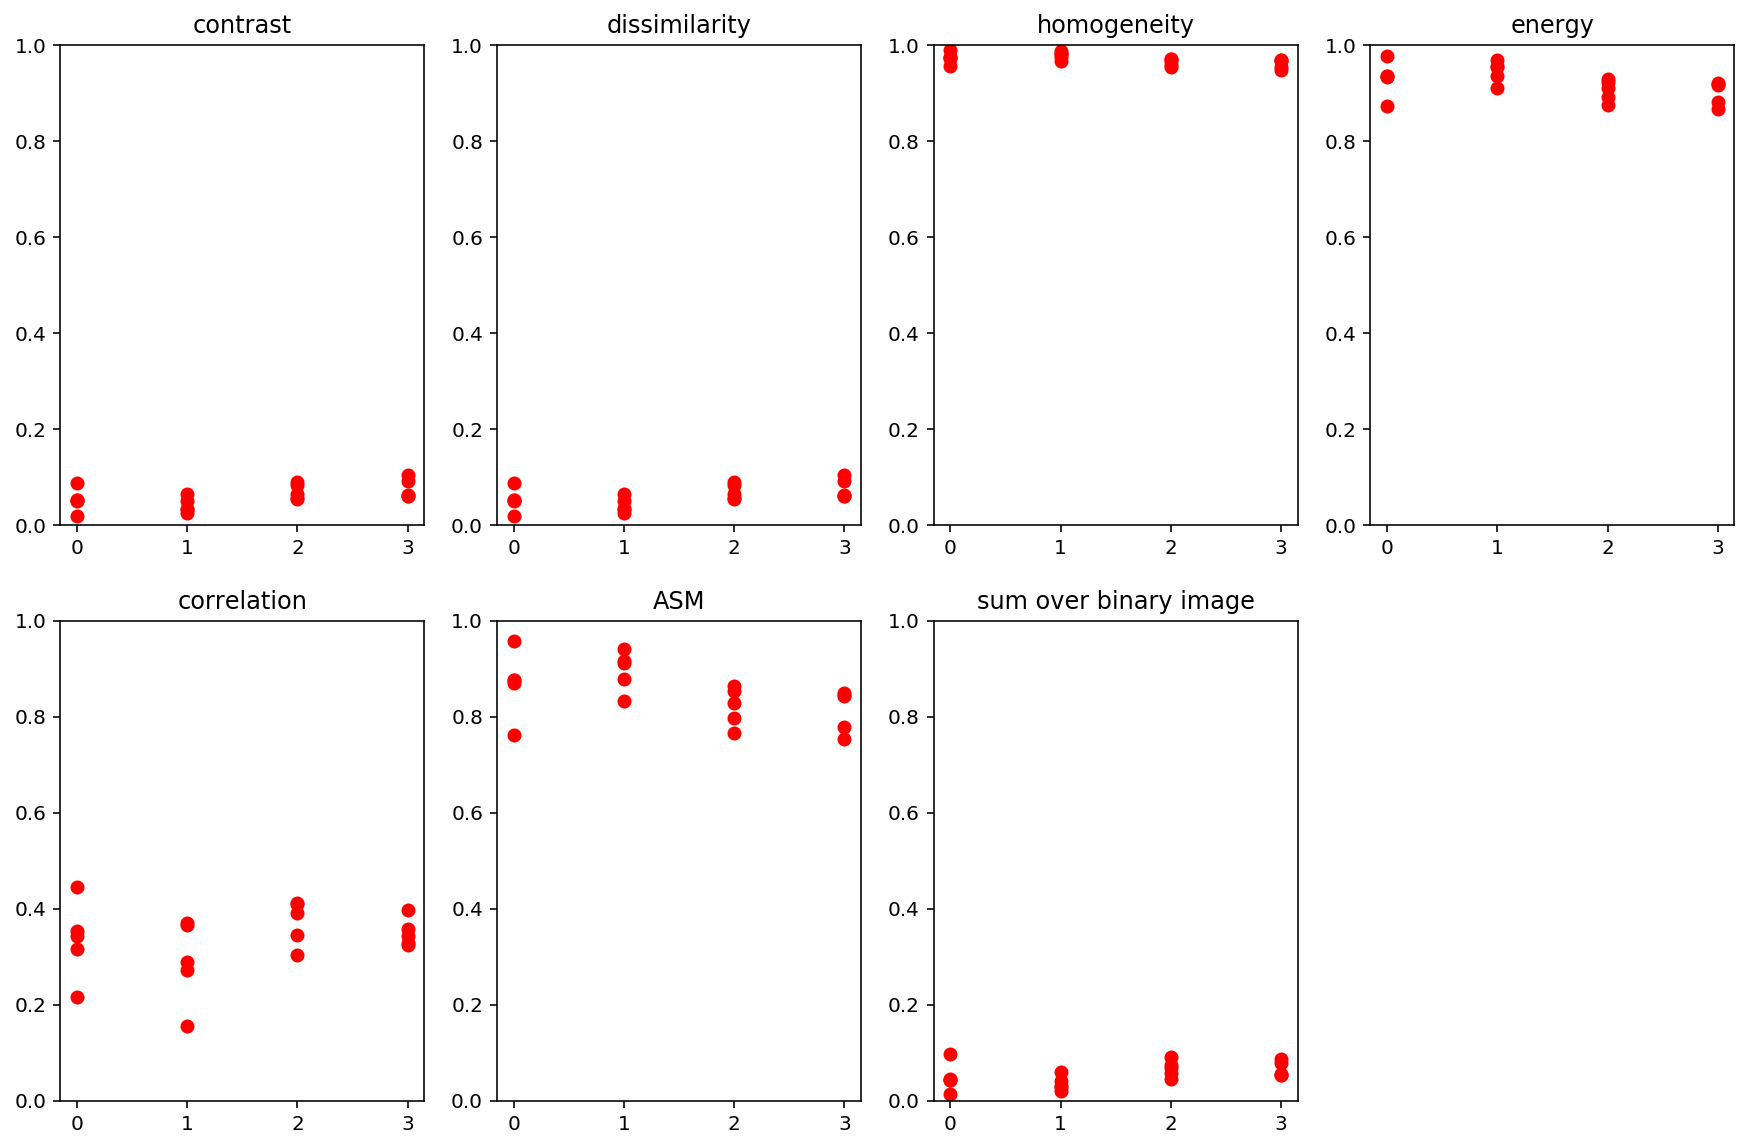

In [120]:
plt.figure(figsize=(15,15))
for i, name in enumerate(feature_types):
    fig = plt.subplot(3, 4, i+1)
    fig.set_title(name)
    plt.ylim(0, 1)
    plt.plot(labels, means[...,i], 'ro')

They only correlate very, very weakly. Some other technique must be explored.